In [1]:
import numpy as np
from matplotlib import pyplot as plt
import cv2

import torch

In [2]:
from configs.config_utilities import load_config
config = load_config()


# Flatten labels

In [3]:
from dataset import NuScenesDataset
dataset = NuScenesDataset(
    nuscenes_dir=config.nuscenes_dir,
    nuscenes_version=config.nuscenes_version,
    label_dir=config.label_dir,
    scene_names=config.train_scenes,
)

--------------------------------------------------
Loading NuScenes version v1.0-mini ...
--------------------------------------------------


In [4]:
image, labels, mask = dataset[0]
print(image.shape)
print(labels.shape)
print(mask.shape)

torch.Size([3, 196, 200])
torch.Size([14, 196, 200])
torch.Size([196, 200])


In [5]:
STATIC_CLASSES = [
    "drivable_area",
    "ped_crossing",
    "walkway",
    "carpark_area",
]
DETECTION_NAMES = [
    "car",
    "truck",
    "bus",
    "trailer",
    "construction_vehicle",
    "pedestrian",
    "motorcycle",
    "bicycle",
    "traffic_cone",
    "barrier",
]
print(len(STATIC_CLASSES + DETECTION_NAMES))

14


In [6]:
labels = labels.detach().numpy()
print("labels", labels.shape)
mask = mask.detach().numpy()
print("mask", mask.shape)

labels (14, 196, 200)
mask (196, 200)


In [7]:
import albumentations as A

def vflip(img: np.ndarray)-> np.ndarray:
    transform = A.Compose([
        A.VerticalFlip(always_apply=True)
    ])
    transformed = transform(image=img)
    return transformed["image"]

14


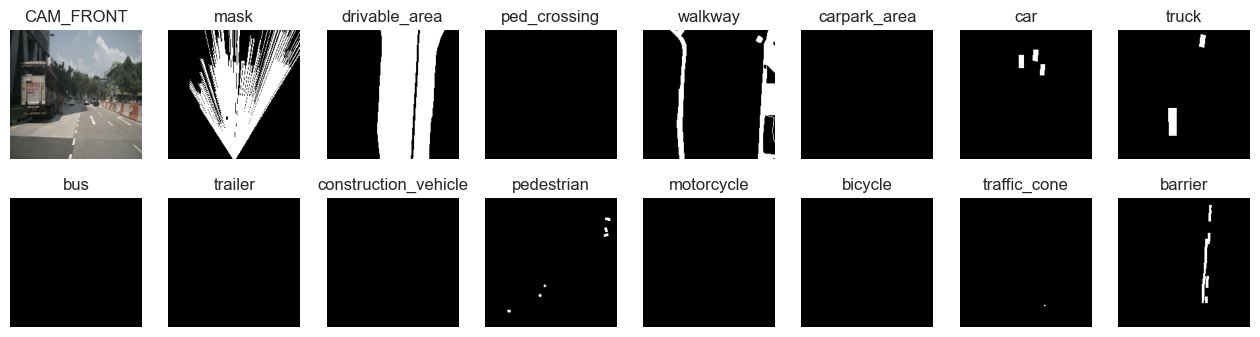

In [8]:
figure, axes = plt.subplots(2,8, figsize=(16,4))

for ax in axes.ravel():
    ax.axis("off")
axes[0, 0].imshow(image.permute(1, 2, 0))
axes[0, 0].title.set_text("CAM_FRONT")
axes[0, 1].imshow(vflip(mask), cmap="gray")
axes[0, 1].title.set_text("mask")

descriptions = STATIC_CLASSES + DETECTION_NAMES
print(len(descriptions))
for ax, label, description in zip(axes.ravel()[2:], labels, descriptions):
    label = vflip(label)
    ax.imshow(label, cmap="gray")
    ax.title.set_text(description)


In [9]:
def flatten_labels(
    labels: np.ndarray,
    mask: np.ndarray = None,
) -> np.ndarray:
    flattened_label = np.zeros_like(labels[0])
    for i, label in enumerate(labels):
        label = label * (i + 1)
        flattened_label = np.maximum(flattened_label, label)
    if mask is not None:
        flattened_label[~mask] = 0
    return flattened_label


(-0.5, 199.5, 195.5, -0.5)

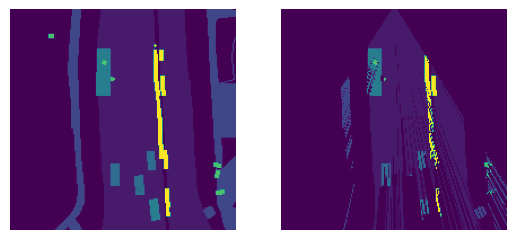

In [10]:
flattened_label = flatten_labels(labels)
flattened_label_with_mask = flatten_labels(labels, mask)

plt.subplot(1,2,1)
plt.imshow(flattened_label, cmap="viridis")
plt.axis("off")

plt.subplot(1,2,2)
plt.imshow(flattened_label_with_mask, cmap="viridis")
plt.axis("off")

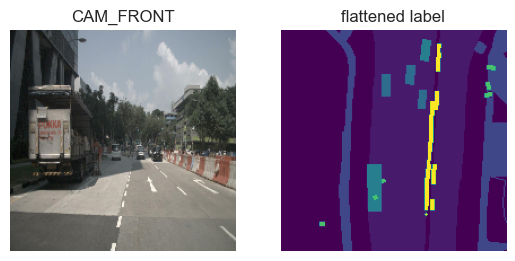

In [11]:
figure, axes = plt.subplots(1,2)

for ax in axes.ravel():
    ax.axis("off")
axes[0].imshow(image.permute(1, 2, 0))
axes[0].title.set_text("CAM_FRONT")
axes[1].imshow(vflip(flattened_label), cmap="viridis")
axes[1].title.set_text("flattened label")

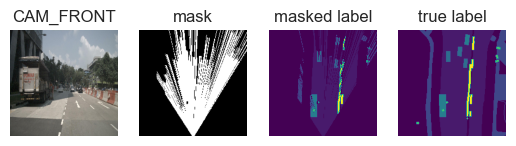

In [12]:
figure, axes = plt.subplots(1,4)

for ax in axes.ravel():
    ax.axis("off")
axes[0].imshow(image.permute(1, 2, 0))
axes[0].title.set_text("CAM_FRONT")
axes[1].imshow(vflip(mask), cmap="gray")
axes[1].title.set_text("mask")
axes[2].imshow(vflip(flattened_label_with_mask), cmap="viridis")
axes[2].title.set_text("masked label")
axes[3].imshow(vflip(flattened_label), cmap="viridis")
axes[3].title.set_text("true label")


(array([1.9007e+04, 1.4066e+04, 0.0000e+00, 4.2450e+03, 0.0000e+00,
        4.2100e+02, 6.6200e+02, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        1.4200e+02, 0.0000e+00, 0.0000e+00, 5.0000e+00, 6.5200e+02]),
 array([ 0.        ,  0.93333333,  1.86666667,  2.8       ,  3.73333333,
         4.66666667,  5.6       ,  6.53333333,  7.46666667,  8.4       ,
         9.33333333, 10.26666667, 11.2       , 12.13333333, 13.06666667,
        14.        ]),
 <BarContainer object of 15 artists>)

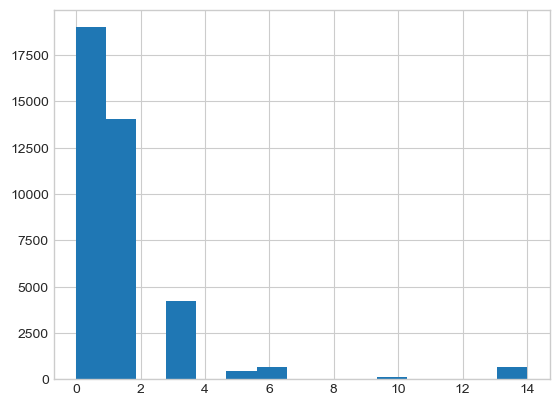

In [13]:
plt.hist(flattened_label.ravel(), bins=15)

# Edit decode label function

## Old Function

In [14]:
def encode_binary_labels(masks):
    bits = np.power(2, np.arange(len(masks), dtype=np.int32))
    # print((masks.astype(np.int32) * bits.reshape(-1, 1, 1)).sum(0))
    return (masks.astype(np.int32) * bits.reshape(-1, 1, 1)).sum(0)

def decode_binary_labels_old(labels, nclass):
    bits = torch.pow(2, torch.arange(nclass))
    return (labels & bits.view(-1, 1, 1)) > 0

# How it works

In [15]:
n_classes = 5
labels = np.random.rand(n_classes,3,3) > 0.5
print(labels.shape)
for label in labels:
    print(label)

(5, 3, 3)
[[False  True False]
 [False False  True]
 [False False False]]
[[ True False  True]
 [False  True False]
 [ True False False]]
[[False  True False]
 [False  True  True]
 [ True  True False]]
[[ True  True False]
 [ True  True False]
 [ True  True False]]
[[False  True False]
 [ True False False]
 [ True  True False]]


In [16]:
encoded_labels = encode_binary_labels(labels)
print(encoded_labels.shape)
print(encoded_labels)

(3, 3)
[[10 29  2]
 [24 14  5]
 [30 28  0]]


In [17]:
bits = 2 ** np.arange(n_classes, dtype=np.int32)
bits = bits.reshape(-1,1,1)
print(bits)

[[[ 1]]

 [[ 2]]

 [[ 4]]

 [[ 8]]

 [[16]]]


In [18]:
bits.dtype

dtype('int32')

In [19]:
encoded_labels = encoded_labels.astype(bits.dtype)


In [20]:
encoded_labels.dtype

dtype('int32')

In [21]:
encoded_labels & bits

array([[[ 0,  1,  0],
        [ 0,  0,  1],
        [ 0,  0,  0]],

       [[ 2,  0,  2],
        [ 0,  2,  0],
        [ 2,  0,  0]],

       [[ 0,  4,  0],
        [ 0,  4,  4],
        [ 4,  4,  0]],

       [[ 8,  8,  0],
        [ 8,  8,  0],
        [ 8,  8,  0]],

       [[ 0, 16,  0],
        [16,  0,  0],
        [16, 16,  0]]], dtype=int32)

In [22]:
(encoded_labels & bits) > 0

array([[[False,  True, False],
        [False, False,  True],
        [False, False, False]],

       [[ True, False,  True],
        [False,  True, False],
        [ True, False, False]],

       [[False,  True, False],
        [False,  True,  True],
        [ True,  True, False]],

       [[ True,  True, False],
        [ True,  True, False],
        [ True,  True, False]],

       [[False,  True, False],
        [ True, False, False],
        [ True,  True, False]]])

In [23]:
((encoded_labels & bits) > 0).shape

(5, 3, 3)

## New Function

In [24]:
def decode_binary_labels(
    encoded_labels: np.ndarray,
    n_classes: int,
) -> np.ndarray:
    bits = 2 ** np.arange(n_classes, dtype=np.int32)
    bits = bits.reshape(-1, 1, 1)
    encoded_labels = encoded_labels.astype(np.int32)
    return (encoded_labels & bits) > 0


In [25]:
import os


sample_data_token = dataset.tokens[0]
filepath = os.path.join(config.label_dir, sample_data_token + ".png")
print(filepath)


labels\e3d495d4ac534d54b321f50006683844.png


In [26]:
encoded_labels = cv2.imread(filepath, cv2.IMREAD_UNCHANGED)
print(encoded_labels.shape)

decoded_labels = decode_binary_labels(encoded_labels, 15)
print(decoded_labels.shape)

(196, 200)
(15, 196, 200)


In [27]:
labels, mask = decoded_labels[:-1], ~decoded_labels[-1]

In [28]:
NUSCENES_CLASS_NAMES = [
    "drivable_area",
    "ped_crossing",
    "walkway",
    "carpark",
    "car",
    "truck",
    "bus",
    "trailer",
    "construction_vehicle",
    "pedestrian",
    "motorcycle",
    "bicycle",
    "traffic_cone",
    "barrier",
]
print(len(NUSCENES_CLASS_NAMES))

14


14


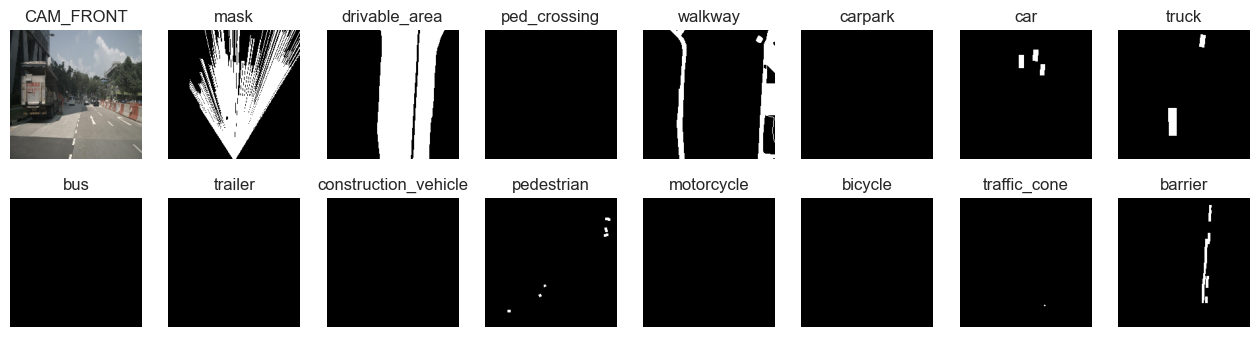

In [29]:
figure, axes = plt.subplots(2,8, figsize=(16,4))

for ax in axes.ravel():
    ax.axis("off")
    
axes[0, 0].imshow(image.permute(1, 2, 0))
axes[0, 0].title.set_text("CAM_FRONT")
axes[0, 1].imshow(vflip(mask), cmap="gray")
axes[0, 1].title.set_text("mask")

descriptions = NUSCENES_CLASS_NAMES
print(len(descriptions))
for ax, label, description in zip(axes.ravel()[2:], labels, descriptions):
    label = vflip(label)
    ax.imshow(label, cmap="gray")
    ax.title.set_text(description)
